# Natural Language Inference mithilfe RoBERTa

Dieses Notebook ist so aufgebaut, dass die verschiedenen Modelle, welche wir im Verlauf des Projektes getestet haben direkt ausgeführt werden können. Wir haben uns während des Projektes auf folgende Modelle von hugging-face konzentriert:
- BERT
- RoBERTa
- xlm-RoBERTa

Zu Beginn ist nur der Code für das Modell RoBERTa aktiviert, da uns dieses am Ende die beste Performance geliefert hat und wir uns grössten Teils mit diesem Modell beschäftigt haben. Es sind bereits alle Zellen ausgeführt, so dass der Output direkt angeschaut werden kann. Zu erwähnen ist, dass wir in diesem Notebokk nur mit den übersetzten Daten arbeiten, wo der gesamte Datensatz ins Englische überetzt wurde. Dies aus dem einfachen Grund, da wie bereits in der Dokumentation erwähnt, dieser Schritt uns bei allen Modellen eine bessere Performance liefert.

Auf folgende Daten, welche sich im selben Hauptordner befinden, wird in diesem Notebook zugegriffen:

Die verschiedenen Datensets
- nlp_train_en.csv
- nlp_valid_en.csv
- nlp_test_en.csv

Das bereits trainierte Modell, damit der Checkpoint geladen werden kann und so nicht das gesamte Modell nochmals trainiert werden muss, da dies ca. 45 Minuten in Anspruch nimmt.
- RoBERTa_en.pth

## 1.1 Import der nötigen Librarys & Settings

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn


from transformers import RobertaTokenizer, RobertaForSequenceClassification

from torch.utils.data import Dataset, DataLoader


# Import für den Optimizer
from transformers import AdamW
from transformers import get_scheduler

# Import zur Berechnung der Performance
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Import zur Visualisierung
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm.auto import tqdm

Hier werden die benötigten Hyperparameter definiert, so dass diese zentral geändert werden können, keine Parameter vergessen gehen und man Zeit spart, falls diese angepasst werden müssen.

In [2]:
# Definieren der Hyperparameter

NUM_LABELS = 3
MAX_LENGTH = 512
BATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 1e-5

# RoBERTa-Modell
MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

# BERT-Modell
#MODEL_NAME = 'bert-base-cased'
#tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
#model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

# xlm-RoBERTa-Modell
#MODEL_NAME = 'xlm-roberta-base'
#tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
#model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [3]:
## Einstellen, dass die GPU verwendet wird, falls eine vorhanden ist.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("There are %d GPU(s) avaiable" % torch.cuda.device_count())
    print("We will user the GPU: ",torch.cuda.get_device_name(0))

else:
    print("No GPU available using the CPU instead")
    device =  torch.device("cpu")

There are 1 GPU(s) avaiable
We will user the GPU:  NVIDIA A16


## 2 Laden der Daten und Vorbereiten für das Modell

In einem ersten Schritt werden die verschiedenen csv-Dateien aus dem Ordner ausgelesn, damit diese hier verwendet werden können.

In [2]:
df_train = pd.read_csv('nlp_train_en.csv')
df_val = pd.read_csv('nlp_valid_en.csv')
df_test = pd.read_csv('nlp_test_en.csv')

In [5]:
class LoadData(Dataset):
    def __init__(self, sentence_1_list, sentence_2_list, labels = None):
        self.sentence_1_list = sentence_1_list
        self.sentence_2_list = sentence_2_list
        self.labels = labels

    def __len__(self):
        return len(self.sentence_1_list)

    def __getitem__(self, idx):
        
        # Anwenden des Tokenizer und vorbereiten des Inputs fürs Modell mit den input_ids und der attention_mask.
        token_dict = tokenizer(
            self.sentence_1_list[idx],self.sentence_2_list[idx],
            padding='max_length',
            truncation=True,
            max_length=MAX_LENGTH, 
            return_tensors = 'pt'
        )
        
        # Der letzte Teil ist für das Testset, da dieses ja noch kein Label enthält. So wird einfach eine 0 übergeben, damit keine Fehlermeldung beim Ausführen kommt.
        if self.labels == None:
            return (token_dict.input_ids[0], token_dict.attention_mask[0])
        else:
            target = torch.tensor(self.labels[idx])
            return (token_dict.input_ids[0], token_dict.attention_mask[0], self.labels[idx])

Es werden zuerst die Premise, die Hypothesis und das Label mit der vorher erstellten Klasse LoadData aus dem jeweiligen csv gelesn. Dabei wird auch der Tokenizer angewendet, wo der Input in input_ids und attention_mask umgewandelt wird. Zudem wird der Input durch das Padding noch erweitert, falls dieser kürzer als 512 Tokens ist oder gekürzt, falls dieser länger ist. Jedoch muss bei uns nicht gekürzt werden, da bei uns kein Satz länger ist.

Mithilfe des DataLoader wird anschliesend dieser Input in ein Tensor umgewandelt, damit dies lesbar fürs Modell ist.

In [6]:
train_dataset = LoadData(df_train['premise_EN'].to_list(), df_train['hypothesis_EN'].to_list(), df_train['label'].to_list())
val_dataset = LoadData(df_val['premise_EN'].to_list(), df_val['hypothesis_EN'].to_list(), df_val['label'].to_list())
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Als nächsten Schritt können wir das bereits trainierte Modell laden, so dass kein neues Training erforderlich ist und wir so Zeit sparen.

In [ ]:
model = torch.load('roberta_checkpoint.pth')

In [7]:
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

Als Optimizer zum finetunen des Modells, verwenden wir hier in unserem Notebook den AdamW-Optimizer von hugging-face mit einer learning-rate von 1e-5. Als loss function verwenden wir die CrossEntropyLoss.

## 3 Training/Validation Loop

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
loss_function = nn.CrossEntropyLoss()

In [9]:
torch.cuda.empty_cache()

In [10]:
loss_per_epoch_training = []
acc_per_epoch_training = []
loss_per_epoch_validation = []
acc_per_epoch_validation = []

for epoch in range(NUM_EPOCHS):
    training_loss = 0
    output_labels_training, actual_labels_training = np.array([]), np.array([])
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader))
    for i, (input_ids, attention_mask, labels) in pbar:
        
        # Laden der vorher definierten Tensors zum device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        output = output.logits
        
        # Berechnen des Loss mithilfe des CrossEntropyLoss
        loss = loss_function(output,labels)
        training_loss += loss.item()
        
        # Aufbereiten der wirklichen Labels sowie den vorhergesagten Labels zur Berechnung der Accuracy
        output_labels = torch.argmax(output,dim=1).cpu().detach().numpy()
        actual_labels = labels.cpu().detach().numpy()
        output_labels_training = np.append(output_labels_training, output_labels)
        actual_labels_training = np.append(actual_labels_training, actual_labels)
        training_accuracy = np.sum(output_labels_training == actual_labels_training) / len(output_labels_training)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        training_desc = f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {training_loss/(i+1):.4f}, Acc: {training_accuracy:.4f}'
        pbar.set_description(desc = training_desc)
        
    avg_training_loss = training_loss / len(train_dataloader)
    loss_per_epoch_training.append(avg_training_loss)
    
    acc_per_epoch_training.append(training_accuracy)
    
    
    
    # ---------------- VALIDATION ----------------
    
    model.eval()
    validation_loss = 0
    output_labels_validation, actual_labels_validation = np.array([]), np.array([])
    pbar = tqdm(enumerate(val_dataloader), total = len(val_dataloader))
    for i, (input_ids, attention_mask, labels) in pbar:
    
        # Laden der vorher definierten Tensors zum device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            output = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
        
        output = output.logits
    
        # Berechnen des Loss mithilfe des CrossEntropyLoss
        loss = loss_function(output,labels)
        validation_loss += loss.item()
    
        # Aufbereiten der wirklichen Labels sowie den vorhergesagten Labels zur Berechnung der Accuracy
        output_labels = torch.argmax(output,dim=1).cpu().detach().numpy()
        actual_labels = labels.cpu().detach().numpy()
        output_labels_validation = np.append(output_labels_validation, output_labels)
        actual_labels_validation = np.append(actual_labels_validation, actual_labels)
        validation_accuracy = np.sum(output_labels_validation == actual_labels_validation) / len(output_labels_validation)
    
        validation_desc = f'Loss: {validation_loss/(i+1):.4f}, Acc: {validation_accuracy:.4f}'
        pbar.set_description(desc = validation_desc)
        
    avg_validation_loss = validation_loss / len(val_dataloader)
    loss_per_epoch_validation.append(avg_validation_loss)
    
    acc_per_epoch_validation.append(validation_accuracy)
    
    print(f"--- TRAINING PERFORMANCE für die Epoche {epoch + 1} ---")
    print(f"Durchschnittlicher train loss für die Epoche {epoch + 1}: {avg_training_loss}")
    print(f"Train accuracy für die Epoche {epoch + 1}: {training_accuracy}")
    print()
    print(f"--- VALIDATION PERFORMANCE für die Epoche {epoch + 1} ---")
    print(f"Durchschnittlicher validation loss für die Epoche {epoch + 1}: {avg_validation_loss}")
    print(f"Validation accuracy für die Epoche {epoch + 1}: {validation_accuracy}")

Loss: 0.5718, Acc: 0.7748: 100%|██████████| 76/76 [00:35<00:00,  2.12it/s]


--- TRAINING PERFORMANCE für die Epoche 1 ---
Durchschnittlicher train loss für die Epoche 1: 0.7321590916676954
Train accuracy für die Epoche 1: 0.6755592225889255

--- VALIDATION PERFORMANCE für die Epoche 1 ---
Durchschnittlicher validation loss für die Epoche 1: 0.5717676487800322
Validation accuracy für die Epoche 1: 0.7747524752475248


Loss: 0.6690, Acc: 0.7657: 100%|██████████| 76/76 [00:35<00:00,  2.12it/s]


--- TRAINING PERFORMANCE für die Epoche 2 ---
Durchschnittlicher train loss für die Epoche 2: 0.3816979069787124
Train accuracy für die Epoche 2: 0.8548771543821049

--- VALIDATION PERFORMANCE für die Epoche 2 ---
Durchschnittlicher validation loss für die Epoche 2: 0.6689637301391677
Validation accuracy für die Epoche 2: 0.7656765676567657


Loss: 0.8459, Acc: 0.7574: 100%|██████████| 76/76 [00:35<00:00,  2.12it/s]


--- TRAINING PERFORMANCE für die Epoche 3 ---
Durchschnittlicher train loss für die Epoche 3: 0.17216182855992984
Train accuracy für die Epoche 3: 0.9371103777044371

--- VALIDATION PERFORMANCE für die Epoche 3 ---
Durchschnittlicher validation loss für die Epoche 3: 0.845939795437612
Validation accuracy für die Epoche 3: 0.7574257425742574


Loss: 0.9295, Acc: 0.7665: 100%|██████████| 76/76 [00:35<00:00,  2.13it/s]


--- TRAINING PERFORMANCE für die Epoche 4 ---
Durchschnittlicher train loss für die Epoche 4: 0.08888284488317565
Train accuracy für die Epoche 4: 0.9713971397139713

--- VALIDATION PERFORMANCE für die Epoche 4 ---
Durchschnittlicher validation loss für die Epoche 4: 0.9294855928930797
Validation accuracy für die Epoche 4: 0.7665016501650165


Loss: 1.1245, Acc: 0.7459: 100%|██████████| 76/76 [00:35<00:00,  2.13it/s]

--- TRAINING PERFORMANCE für die Epoche 5 ---
Durchschnittlicher train loss für die Epoche 5: 0.055797071636366304
Train accuracy für die Epoche 5: 0.9822148881554822

--- VALIDATION PERFORMANCE für die Epoche 5 ---
Durchschnittlicher validation loss für die Epoche 5: 1.1245284242751568
Validation accuracy für die Epoche 5: 0.7458745874587459


In [11]:
# Berechnen des F1-Score für das Trainingset
f1_score(actual_labels_training, output_labels_training, average='weighted')

0.982212615076582

In [12]:
# Berechnen des F1-Score für das Validationset
f1_score(actual_labels_validation, output_labels_validation, average='weighted')

0.7411409625958263

Als nächstes bietet sich die Möglichkeit das so eben trainierte Modell zu speichern, damit dies später nochmals genutzt werden kann und nicht neu trainiert werden muss.

In [13]:
torch.save(model, "roberta_checkpoint_ z.pth")

## 4 Visualisierungen

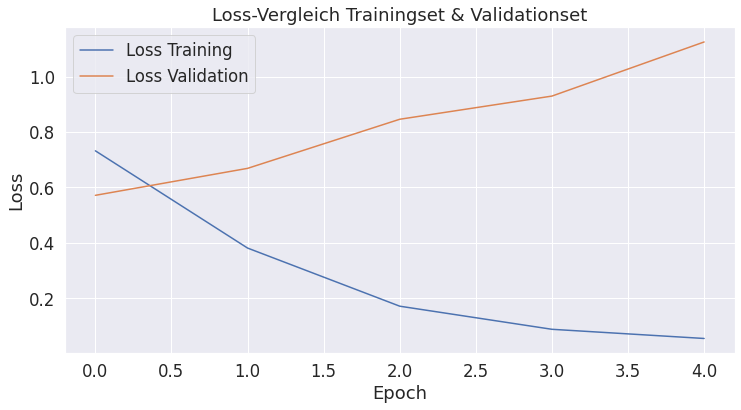

In [14]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_per_epoch_training, label="Loss Training")
plt.plot(loss_per_epoch_validation, label="Loss Validation")


plt.title("Loss-Vergleich Trainingset & Validationset")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.show()

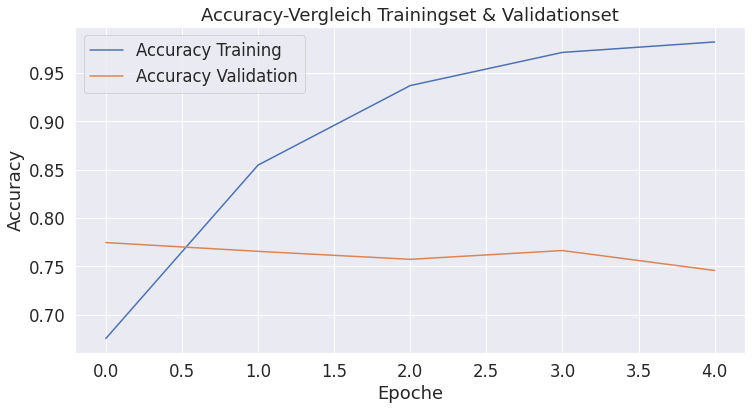

In [15]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(acc_per_epoch_training, label="Accuracy Training")
plt.plot(acc_per_epoch_validation, label="Accuracy Validation")


plt.title("Accuracy-Vergleich Trainingset & Validationset")
plt.xlabel("Epoche")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

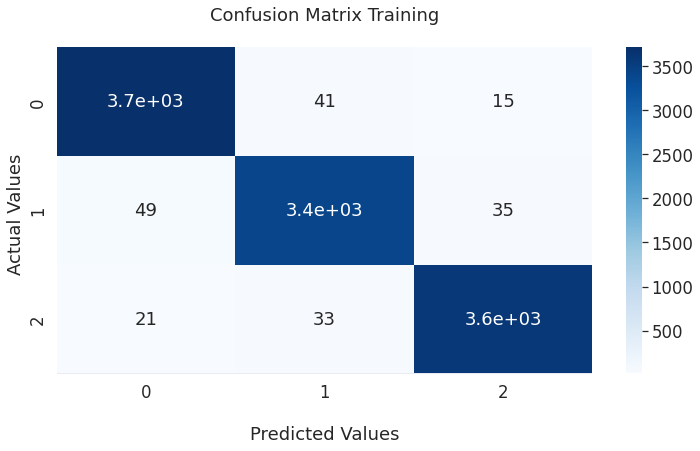

In [16]:
labels = list(df_train['label'])
cf_matrix = confusion_matrix(actual_labels_training, output_labels_training)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix Training\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels([0,1,2])
ax.yaxis.set_ticklabels([0,1,2])

plt.show()

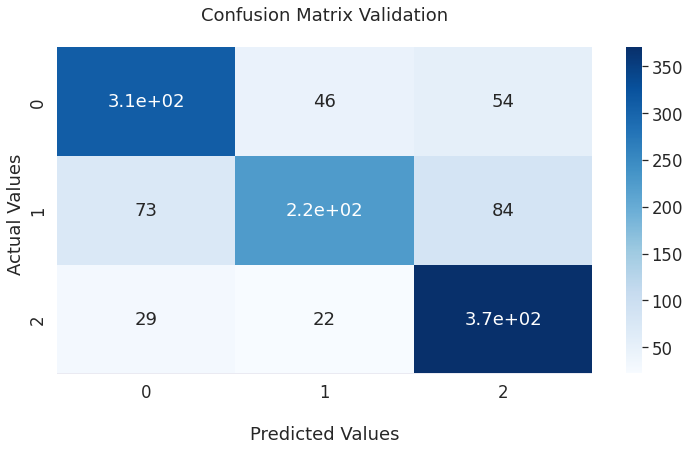

In [17]:
labels = list(df_train['label'])
cf_matrix = confusion_matrix(actual_labels_validation, output_labels_validation)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix Validation\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels([0,1,2])
ax.yaxis.set_ticklabels([0,1,2])

plt.show()

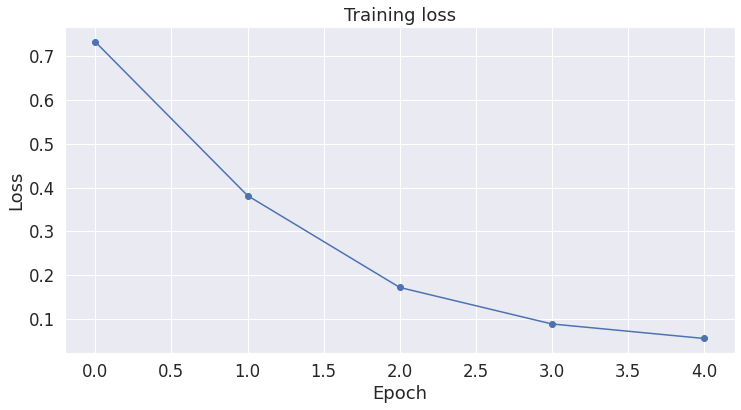

In [18]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_per_epoch_training, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

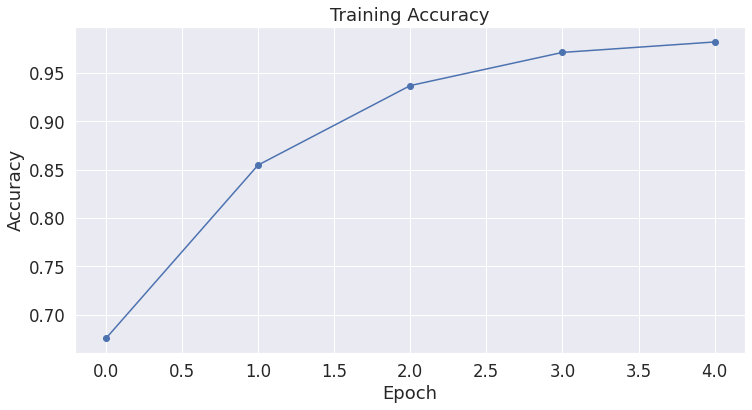

In [19]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(acc_per_epoch_training, 'b-o')

plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

In [20]:
torch.cuda.empty_cache()

## 5 Validation

Falls ein bereits trainiertes Modell geladen wird kann hier die Performance am Validationset direkt getestet werden.

In [21]:
model.eval()
train_loss = 0
output_labels_in_epoch, actual_labels_in_epoch = np.array([]), np.array([])
pbar = tqdm(enumerate(val_dataloader), total = len(val_dataloader))
for i, (input_ids, attention_mask, labels) in pbar:
    
    # Laden der vorher definierten Tensors zum device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        
    output = output.logits
    
    # Berechnen des Loss mithilfe des CrossEntropyLoss
    loss = loss_function(output,labels)
    train_loss += loss.item()
    
    # Aufbereiten der wirklichen Labels sowie den vorhergesagten Labels zur Berechnung der Accuracy
    output_labels = torch.argmax(output,dim=1).cpu().detach().numpy()
    actual_labels = labels.cpu().detach().numpy()
    output_labels_in_epoch = np.append(output_labels_in_epoch, output_labels)
    actual_labels_in_epoch = np.append(actual_labels_in_epoch, actual_labels)
    acc = np.sum(output_labels_in_epoch == actual_labels_in_epoch) / len(output_labels_in_epoch)
    
    train_desc = f'Loss: {train_loss/(i+1):.4f}, Acc: {acc:.4f}'
    pbar.set_description(desc = train_desc)

Loss: 1.1245, Acc: 0.7459: 100%|██████████| 76/76 [00:35<00:00,  2.13it/s]


In [22]:
# Berechnen des F1-Score für das Validationset
f1_score(actual_labels_in_epoch, output_labels_in_epoch, average='weighted')

0.7411409625958263

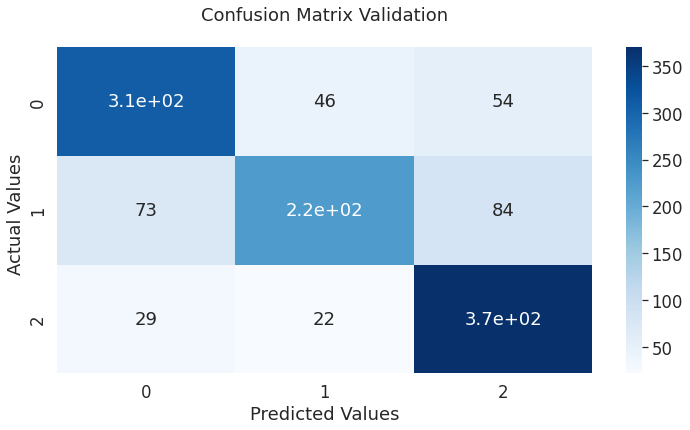

In [23]:
labels = list(df_train['label'])
cf_matrix = confusion_matrix(actual_labels_in_epoch, output_labels_in_epoch)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix Validation\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels([0,1,2])
ax.yaxis.set_ticklabels([0,1,2])

plt.show()

## 6 Prediction für das Testset

In [24]:
test_dataset = LoadData(df_test['premise_EN'].to_list(), df_test['hypothesis_EN'].to_list(), labels = None)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
result_labels = np.array([])
with torch.no_grad():
    pbar = tqdm(enumerate(test_dataloader), total = len(test_dataloader))
    for i, (input_ids, attention_mask) in pbar:
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        
        output_label = torch.argmax(output.logits,dim=1).cpu().detach().numpy()
        result_labels = np.append(result_labels,output_label)

100%|██████████| 325/325 [02:32<00:00,  2.12it/s]


In [26]:
df_test['prediction'] = result_labels
df_test['prediction'] = df_test['prediction'].astype('int')
df_test[['id','prediction']].to_csv('submission.csv',index=False)